# Introduction

**Objective:**  
Engineer a product recommendation system for an e-commerce website to increase customer retention and sales.

**Featured Techniques:**
* Feature Engineering
* Collaborative Filtering
* Surprise Package SVD

**Methodology:**  
Users are separated into repeat customers and first time customers and the recommendation system works as follows. 
* Repeat Customers
    * Collaborative filtering recommendation
    * Hot Products
    * Popular in your area
    
* New Customers
    * Hot products
    * Popular in your area

**Data:** 
https://www.kaggle.com/olistbr/brazilian-ecommerce#olist_products_dataset.csv

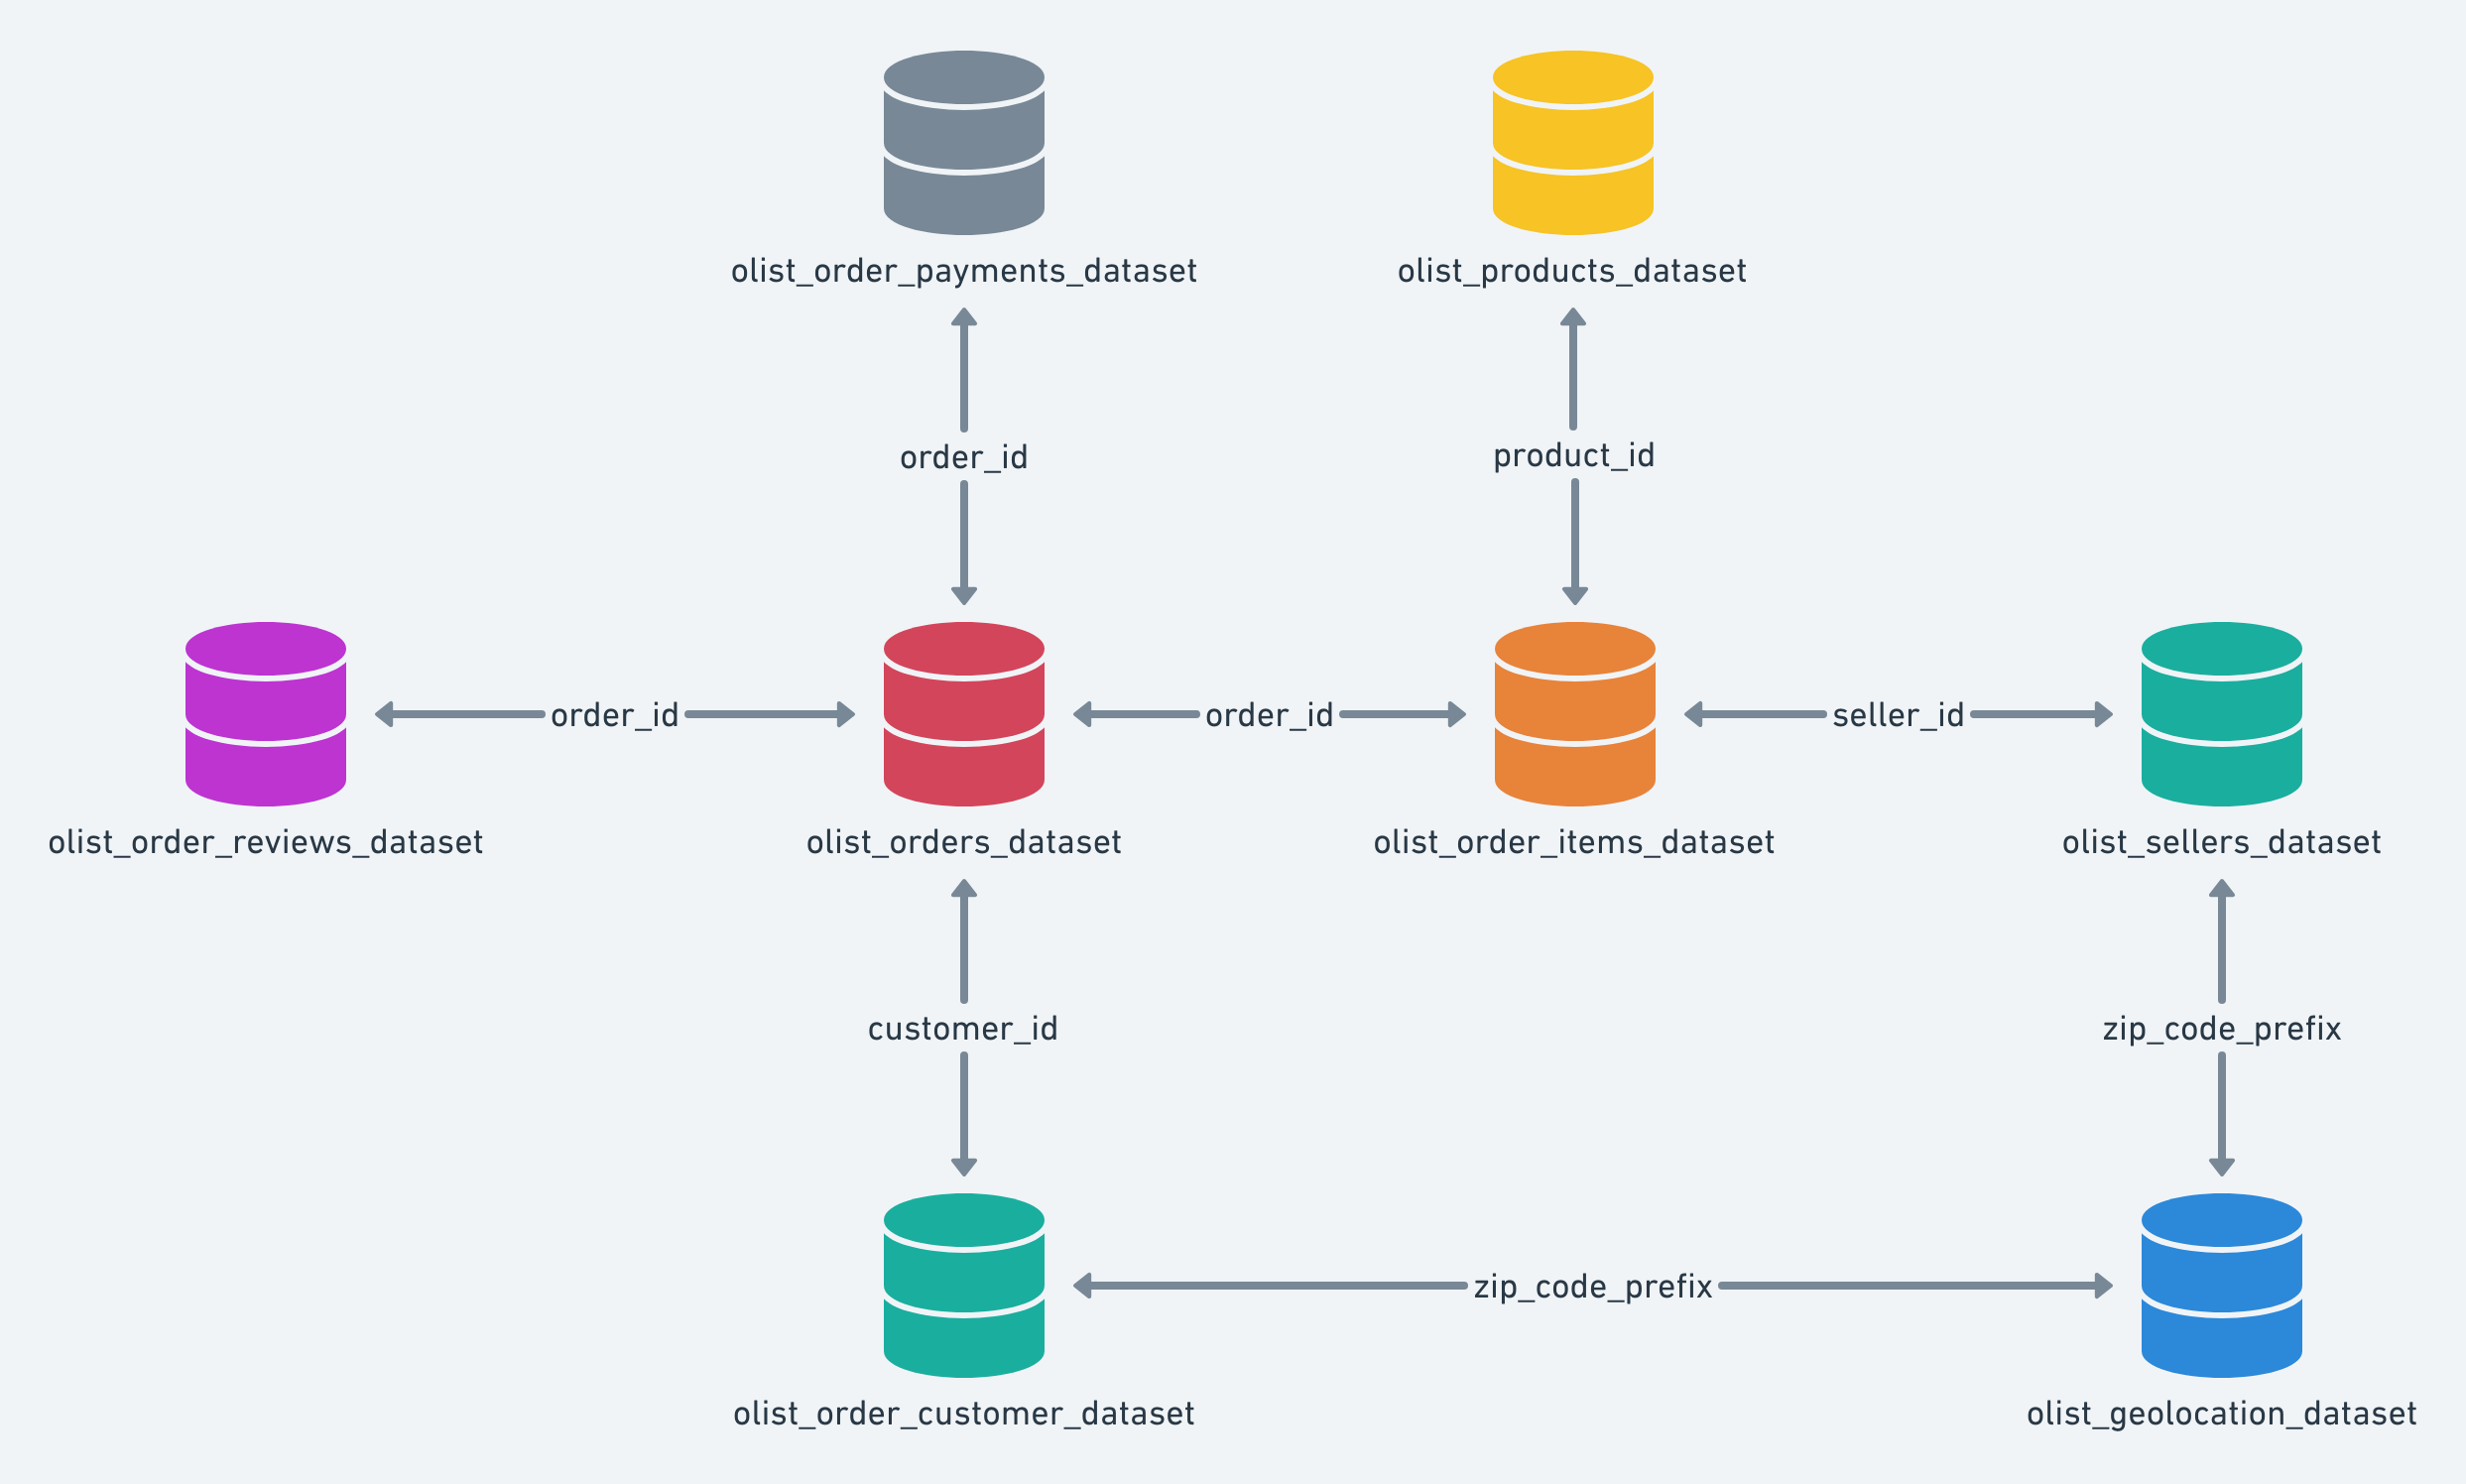

In [2]:
# Display database schema in AWS PostgreSQL
from IPython.display import Image
Image("HRhd2Y0.png")

In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict

import psycopg2 as pg
import pandas.io.sql as pd_sql
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

from sqlalchemy import create_engine

from scipy import stats

from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD, SVDpp, KNNBasic, CoClustering, SlopeOne
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
from datetime import datetime

from connect_to_aws import connect

# Connecting to AWS Postgres

In [18]:
# call function stored separately that connects to postgres database in AWS 
conneciton, engine = connect_to_aws()

# Loading and Cleaning Data

## Querying Data With SQL

In [20]:
def query_aws(query, engine):
    return pd.read_sql(query,engine)

In [22]:
query = """
        SELECT 
            customers.customer_unique_id, 
            customers.customer_zip_code_prefix, 
            customers.customer_city,
            customers.customer_state,
            order_item.order_id,
            order_item.product_id,
            order_item.seller_id,
            order_item.price,
            orders.order_purchase_timestamp,
            orders.order_delivered_customer_date,
            orders.order_estimated_delivery_date,
            payments.payment_type,
            payments.payment_installments,
            payments.payment_value,
            reviews.review_score,
            products.product_weight_g,
            product_category.product_category_name_english,
            sellers.seller_zip_code_prefix,
            sellers.seller_state,
            sellers.seller_state
        FROM customers
            JOIN orders
                on orders.customer_id=customers.customer_id
            JOIN reviews
                on reviews.order_id=orders.order_id
            JOIN order_item
                on order_item.order_id=orders.order_id
            JOIN payments
                on payments.order_id=orders.order_id
            JOIN products
                on products.product_id=order_item.product_id
            JOIN product_category
                on product_category.product_category_name=products.product_category_name
            JOIN sellers
                on sellers.seller_id=order_item.seller_id
            
        """

olist_data = query_aws(query, engine)

In [23]:
# Save dataset to csv file
olist_data.to_csv('data/01_olist_aws_pulled.csv')

In [363]:
# If needed, unhash to load dataset
# olist_data = pd.read_csv('data/01_olist_aws_pulled.csv')

## Viewing and Cleaning

In [364]:
olist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 21 columns):
Unnamed: 0                       116581 non-null int64
customer_unique_id               116581 non-null object
customer_zip_code_prefix         116581 non-null int64
customer_city                    116581 non-null object
customer_state                   116581 non-null object
order_id                         116581 non-null object
product_id                       116581 non-null object
seller_id                        116581 non-null object
price                            116581 non-null float64
order_purchase_timestamp         116581 non-null object
order_delivered_customer_date    114066 non-null object
order_estimated_delivery_date    116581 non-null object
payment_type                     116581 non-null object
payment_installments             116581 non-null int64
payment_value                    116581 non-null float64
review_score                     116581 non-null i

In [365]:
olist_data = olist_data.drop(columns=['Unnamed: 0', 'seller_state.1'])

In [366]:
# some purchases are payed with by vouchers which causes them to split into many lines of
# smaller payments. To normalize with the rest of the data, combining these values into 
# one total payment value

def create_total_payment_value(data):
    data['total_payment'] = data['payment_value'].groupby(data['order_id']).transform('sum')
    data= data.drop('payment_value', axis=1)
    return data

In [367]:
olist_data = create_total_payment_value(olist_data)

In [368]:
def duplicates(data):
    """
    Prints the number of duplicates in the input dataset, removes duplicate values keeping only the 
    first entry, and returns a dataset with no duplicate values.
    """
    
    # Confirm number of duplicate rows
    print(f"There are {data.duplicated().sum()} duplicate rows.")

    # Remove any duplicates, keeping only the first entry
    data = data.drop_duplicates(keep='first')

    # Confirm duplicates were removed correctly
    print(f"After dropping, there are {data.duplicated().sum()} duplicate rows.")
    print(f"Returned dataset has {data.shape[0]} rows")
    
    return data

In [369]:
olist_data = duplicates(olist_data)

There are 12969 duplicate rows.
After dropping, there are 0 duplicate rows.
Returned dataset has 103612 rows


In [408]:
# Convert order timestamp to datetime 
def convert_to_datetime(data):
    """
    Converts order_purchase, order_delivered, and order_estimated_delivery_date to 
    datetime objects.
    """
    data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp, 
                                                     format="%Y/%m/%d %H:%M:%S")
    data.order_delivered_customer_date = pd.to_datetime(data.order_delivered_customer_date, 
                                                        format="%Y/%m/%d %H:%M:%S")
    data.order_estimated_delivery_date = pd.to_datetime(data.order_estimated_delivery_date, 
                                                        format="%Y/%m/%d %H:%M:%S")
    return data

olist_data = convert_to_datetime(olist_data)

In [371]:
# Adding 99% to 7 digit summary to understand how drastic the max_price outlier is
olist_data.describe([.75,.99])

customer_zip_code_prefix          price  payment_installments  \
count             103612.000000  103612.000000         103612.000000   
mean               35125.539918     124.490286              2.937150   
std                29771.870475     188.972184              2.743117   
min                 1003.000000       0.850000              0.000000   
50%                24435.000000      78.000000              2.000000   
75%                58741.250000     139.000000              4.000000   
99%                97541.000000     899.000000             10.000000   
max                99980.000000    6735.000000             24.000000   

        review_score  product_weight_g  seller_zip_code_prefix  total_payment  
count  103612.000000     103611.000000           103612.000000  103612.000000  
mean        4.061489       2096.389785            24627.129126     231.038923  
std         1.364238       3750.600705            27678.848789     692.432702  
min         1.000000          0.000000             1001.000000       9.590000  
50%         5.000000        700.000000            13720.000000     114.760000  
75%         5.000000       1800.000000            29156.000000     212.092500  
99%         5.000000      18250.000000            93542.000000    1957.020000  
max         5.000000      40425.000000            99730.000000  109312.640000

In [372]:
# For now, not removing outliers but note that price and payment values both contain significan outliers

In [410]:
# Save to CSV to access later
olist_data.to_csv('data/cleaned_olist_data.csv', index=False)

In [93]:
# Unhash to access cleaned olist dataset
#olist_data=pd.read_csv('data/cleaned_olist_data.csv')

# EDA

In [15]:
olist_blue  = '#0C29D1'
olist_green = '#0CC78B'

## Consumers

In [7]:
def general_customer_info(data):
    """Returns number of unique and repeat customers in the dataset."""
    print("Number of unique customers:", data.customer_unique_id.nunique())
    
    customer_count = data.customer_unique_id.value_counts()
    print("Number of repeat customers:", customer_count[customer_count > 1].count())

    return

general_customer_info(olist_data)

Number of unique customers: 94087
Number of repeat customers: 7788


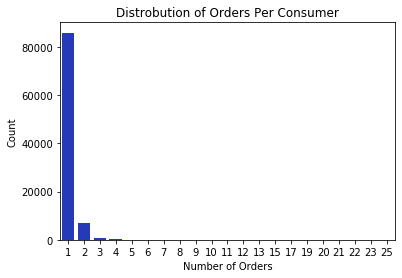

In [412]:
# Distrobution of orders per customer

def order_per_consumer(data):
    return data.groupby('customer_unique_id')['order_id'].agg(['count'])
    
orders_per_consumer = order_per_consumer(olist_data)

fig = plt.figure(figsize=(6,4))
ax = fig.gca()
sns.countplot(orders_per_consumer['count'], color=olist_blue)
ax.set(xlabel='Number of Orders', ylabel='Count', title='Distrobution of Orders Per Consumer');

In [255]:
# Customer locations throughout Brazil

def customer_geography(data):
    customer_locations = pd.DataFrame(data.customer_city.value_counts().sort_values(ascending=False))
    customer_locations = customer_locations(olist_data).reset_index().rename(columns={'index': 'city', 'customer_city':'num_customers'})
    
    print(f"There are {customer_locations.city.nunique()} unique customer cities.\n")
    
    top_ten_cities = customer_locations.city[:10]
    customers_in_top_ten_cities = round(customer_locations.num_customers[:10].sum()/customer_locations.num_customers.sum()*100,2)

    print(f"The majority of customers, {customers_in_top_ten_cities} percent, live in the top ten cities.\n")

    return customer_locations, top_ten_cities

customer_locations, top_ten_cities = customer_geography(olist_data)

There are 4095 unique customer cities.

The majority of customers, 35.22 percent, live in the top ten cities.



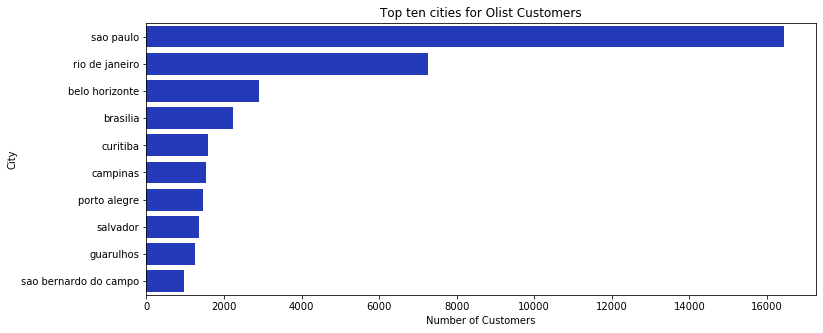

In [413]:
# plot top cities
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
sns.barplot(x=customer_locations.num_customers[:10], y=top_ten_cities, ax=ax, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='City', title='Top ten cities for Olist Customers');

## Orders

In [107]:
# Number of orders per day

def order_per_day(data):
    order_per_day = data.groupby(data.order_purchase_timestamp.dt.date)['order_id'].agg(['count'])
    print(f"Avg. number of orders per day: {np.mean(order_per_day)[0]}")
    
    return order_per_day

order_per_day = order_per_day(olist_data)

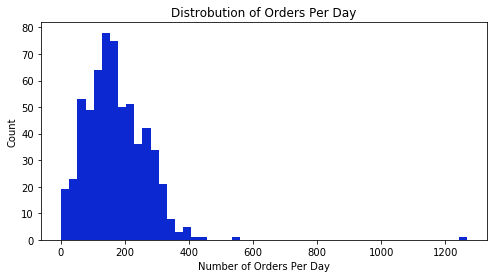

In [414]:
# Distrobution of orders per day
plt.figure(figsize=(8,4))
plt.hist(order_per_day['count'], bins=50, color=olist_blue)
plt.xlabel('Number of Orders Per Day')
plt.ylabel('Count')
plt.title('Distrobution of Orders Per Day');

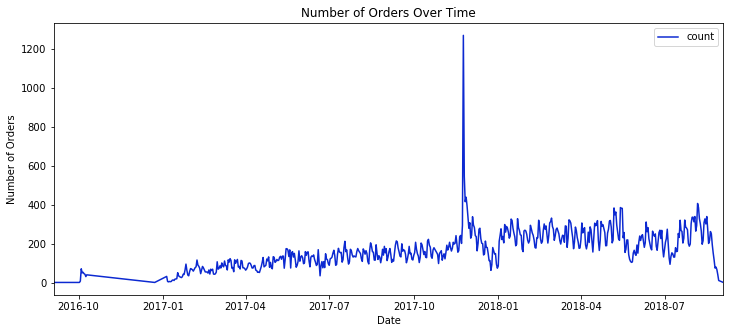

In [415]:
# plot number of orders over time
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
order_per_day.plot(ax=ax, use_index=True, color=olist_blue)
ax.set(xlabel='Date', ylabel='Number of Orders', title='Number of Orders Over Time');

There is a spike in orders around Christmas of 2017 but otherwise we see a pattern of general inflation of orders 

Avg. purchase price: 159.2856598632461


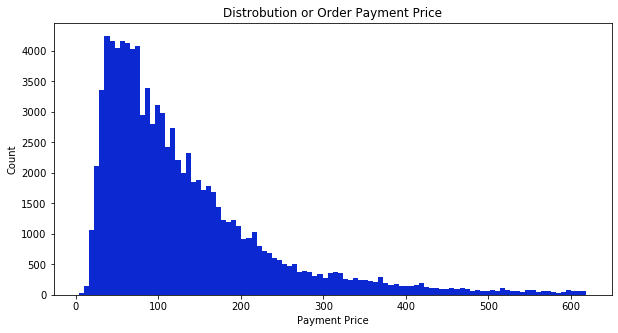

In [416]:
# Each line item represents a single item in an order. 
# Group by order_id to find total purchase price for all orders

def purchase_payment_val(data):
    purchase_payments = data.groupby('order_id').payment_value.max()
    print(f"Avg. purchase price: {purchase_payments.mean()}")
    
    return purchase_payments


# view purchase price removing outliers in the top 3%
q_97 = purchase_payments.quantile(.97)
payments_97 = purchase_payments[purchase_payments < q_97]

# plot distrobution
plt.figure(figsize=(10,5))
plt.hist(payments_97, bins=100, color=olist_blue)
plt.xlabel('Payment Price')
plt.ylabel('Count')
plt.title('Distrobution or Order Payment Price');

In [101]:
# Number of items per order
def items_per_order(data):
    item_orders = data.groupby('order_id').product_id.agg(['count']).sort_values(by='count')
    avg_items_per_order = item_orders.mean()
    print(f"Average number of items per order: {avg_items_per_order}")
    return avg_items_per_order

avg_items_per_order = items_per_order(olist_data)

Average number of items per order: count    1.065364
dtype: float64


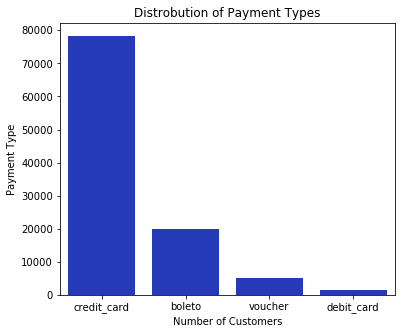

In [417]:
# Payment methods
def payment_types(data):
    return data.payment_type.value_counts()

payment_types = payment_types(olist_data)

fig = plt.figure(figsize=(6,5))
ax = fig.gca()
sns.barplot(x=payment_types.index, y=payment_types.values, color=olist_blue)
ax.set(xlabel='Number of Customers', ylabel='Payment Type', title='Distrobution of Payment Types');

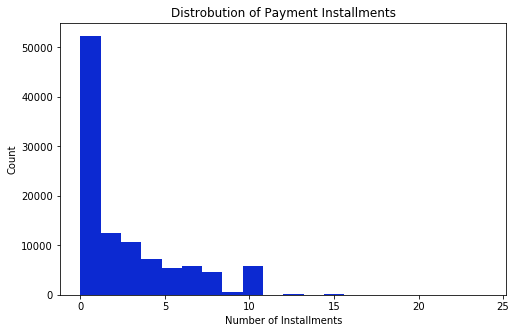

In [418]:
# Installments
plt.figure(figsize=(8,5))
plt.hist(olist_data.payment_installments, color=olist_blue, bins=20)
plt.xlabel('Number of Installments')
plt.ylabel('Count')
plt.title('Distrobution of Payment Installments');

## Sellers

Avg. number of sales per seller: 34.16155621496868

The top 10 sellers account for 14.24 percent of the total sales

The top seller has 2034 sales


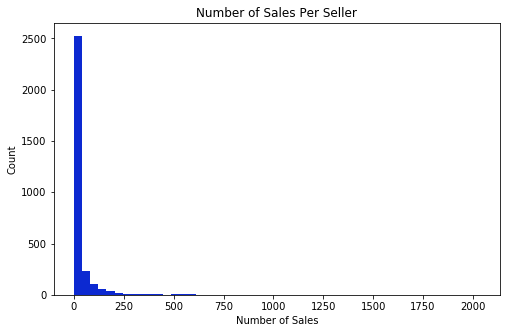

In [102]:
def sales_per_seller(data):
    """
    Returns the average number of sales per Olist seller, the magnitude of the top 10 sellers,
    and the number of sales that the top seller has made.
    """
    
    sales_per_seller = data.groupby('seller_id')['order_id'].count()
    print(f"Avg. number of sales per seller: {sales_per_seller.mean()}\n")
    
    top_ten_sellers = sales_per_seller.sort_values(ascending=False)[:10]
    sales_in_top_ten_sellers = round(top_ten_sellers.values.sum()/sales_per_seller.values.sum()*100,2)

    print(f"The top 10 sellers account for {sales_in_top_ten_sellers} percent of the total sales\n")

    print(f"The top seller has {top_ten_sellers[0]} sales")

    return sales_per_seller

sales_per_seller = sales_per_seller(olist_data)


plt.figure(figsize=(8,5))
plt.hist(sales_per_seller, bins=50, color=olist_blue)
plt.xlabel('Number of Sales')
plt.ylabel('Count')
plt.title('Number of Sales Per Seller');

## Products

Number of unique products: 32328

Average price per product: 124.49028568119523

Average sales per product: 3.2050235090324177

Top ten selling products:
99a4788cb24856965c36a24e339b6058    489
aca2eb7d00ea1a7b8ebd4e68314663af    434
422879e10f46682990de24d770e7f83d    363
d1c427060a0f73f6b889a5c7c61f2ac4    325
389d119b48cf3043d311335e499d9c6b    320
53b36df67ebb7c41585e8d54d6772e08    310
368c6c730842d78016ad823897a372db    297
53759a2ecddad2bb87a079a1f1519f73    293
154e7e31ebfa092203795c972e5804a6    274
2b4609f8948be18874494203496bc318    263
Name: product_id, dtype: int64

The top ten selling products account for 3.25 percent of the product sold.



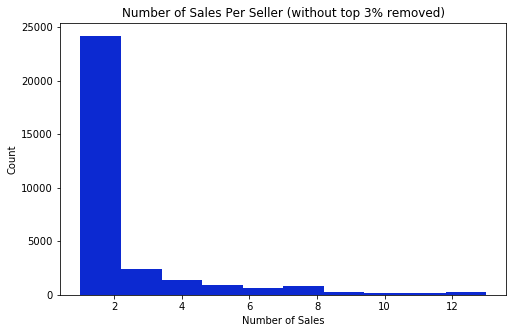

In [13]:
# Average product cost
def product_sales_info(data, olist_blue):
    """
    Identifies number of unique products sold at olist, the average price per product, the
    average number of sales per product. and a list of the top ten products. Plots the 
    distrobution of sales per product.
    """
    
    print(f"Number of unique products: {data.product_id.nunique()}\n")
    print(f"Average price per product: {data.price.mean()}\n")
    
    number_prod_sold = data.product_id.value_counts()
    print(f"Average sales per product: {np.mean(number_prod_sold)}\n")
    
    # top products
    top_ten_products = number_prod_sold[:10]
    print(f"Top ten selling products:\n{top_ten_products}\n")
    print(f"The top ten selling products account for {round(top_ten_products.values.sum()/number_prod_sold.values.sum()*100,2)} percent of the product sold.\n")

    p_q_97 = number_prod_sold.quantile(.97)
    products_q_97 = number_prod_sold[number_prod_sold < p_q_97]

    plt.figure(figsize=(8,5))
    plt.hist(products_q_97, bins=10, color=olist_blue)
    plt.xlabel('Number of Sales')
    plt.ylabel('Count')
    plt.title('Number of Sales Per Seller (without top 3% removed)');
    
    return

product_sales_info(olist_data, olist_blue)

The top reviewed products are
                              product_id  mean  count
5081   2722b7e5f68e776d18fe901638034e54   5.0     13
9761   4c8b28305f570899b6ded964ddd234a9   5.0     12
11433  59c1840441f4df065f52760bf51a8442   5.0     11
16420  8173ca41cdb176462f9ae79821a48404   5.0     11
17603  8b6ed41158b194711f83b8da92757544   5.0     11
16705  83aae8023b8feda53259f63e0ec06390   5.0     10
21112  a7d756e8f7c4b7e5b679e248a57d91ec   5.0     10
23444  b9ee7519d0187d2389af62ba6c612963   5.0     10
31055  f5d8f4fbc70ca2a0038b9a0010ed5cb0   5.0     10
7821   3d36ef6c6d553500f4240920658689e3   5.0      9


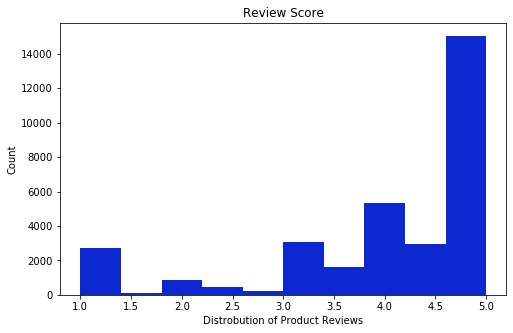

In [103]:
# Top reviewed products as determined by rating and number of reviews
def product_reviews(data):
    reviewed_products = data.groupby('product_id')['review_score'].agg(['mean', 'count']).reset_index()
    top_ten_reviewed_products = reviewed_products.sort_values(by=['mean','count'],ascending=False)[:10]

    print(f"The top reviewed products are\n {top_ten_reviewed_products}")
    
    return reviewed_products

reviewed_products = product_reviews(olist_data)


plt.figure(figsize=(8,5))
plt.hist(reviewed_products['mean'], bins=10, color=olist_blue)
plt.xlabel('Distrobution of Product Reviews')
plt.ylabel('Count')
plt.title('Review Score');

<Figure size 432x360 with 0 Axes>

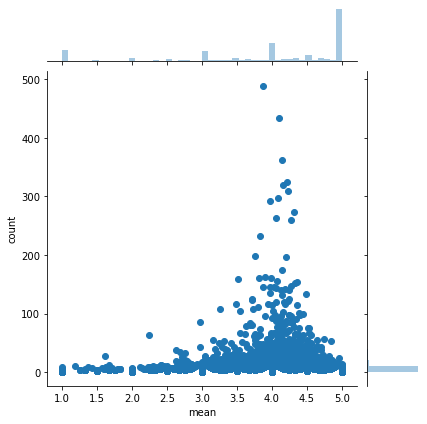

In [28]:
# observe the relationship between rating and number of reviews
fig = plt.figure(figsize=(6,5))
ax = sns.jointplot(x=reviewed_products['mean'], y=reviewed_products['count'], data=reviewed_products);

There are 71 categories


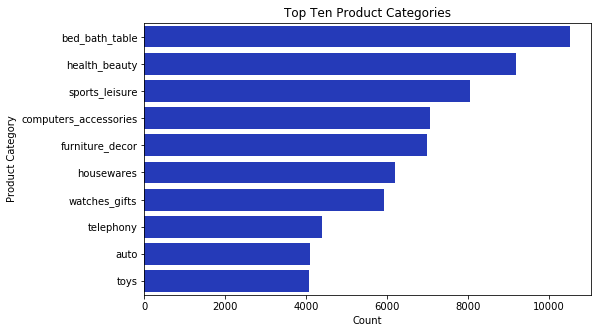

In [105]:
# Product cateogires

def product_categories():
    print(f"There are {olist_data.product_category_name_english.nunique()} categories")

    top_ten_categories = olist_data.product_category_name_english.value_counts().sort_values(ascending=False)[:10]

    plt.figure(figsize=(8,5))
    ax = sns.barplot(top_ten_categories.values, top_ten_categories.index, color=olist_blue)
    ax.set(xlabel='Count', ylabel='Product Category', title='Top Ten Product Categories');
    
    return

product_categories()

# Feature Engineering

When entering the site, the customers are flagged as a repeat customer or new customer and handled as follows.  

**Repeat Customers:** Collaborative filtering is used to recommend products. Results are measured by how many predictions are right using the recommender vs. how many are right when just recommending the most popular item.  

**For New Users:** Recommendation based on 
* Customer Segmentation, then pick the top product in that customer base
* People in your area, then pick the top products in that customer base   

Results are measured by comparing predictions to the overall most popular item

In [346]:
def repeat_and_first_time(data):
    """Takes in a dataset and returns back the dataset with only repeated customers"""
    repeaters = data.groupby('customer_unique_id').filter(lambda x: len(x) > 1)
    first_timers = data.groupby('customer_unique_id').filter(lambda x: len(x) == 1)
    
    # Save datasets for easier accessing
    repeater_data.to_csv('data/repeater_data.csv')
    first_timer_data.to_csv('data/first_timer_data.csv')
    
    print("Shape of repeater dataset:", repeater_data.shape)

    print("Shape of first timer dataset:", first_timer_data.shape)

    return repeaters, first_timers

In [348]:
repeater_data, first_timer_data = repeat_and_first_time(olist_data)

In [10]:
# Unhash to load datasets
#repeater_data = pd.read_csv('data/repeater_data.csv')
#first_timer_data = pd.read_csv('data/first_timer_data.csv')

In [29]:
def regenerate_dataset_with_indicators(repeater_data, first_timer_data):
    repeater_data['repeater'] = 1
    first_timer_data['repeater'] = 0
    
    full_df = pd.concat((repeater_data, first_timer_data), axis=0).drop('Unnamed: 0', axis=1).reset_index()
    print("full_df shape:", full_df.shape)
    return full_df

full_df = regenerate_dataset_with_indicators(repeater_data, first_timer_data)

full_df shape: (103612, 21)


Additional features are also added to the dataset to explore the delivery process and seller performance.

In [ ]:
def full_def_feature_engineering(data):
    data.order_purchase_timestamp = pd.to_datetime(data.order_purchase_timestamp).dt.date
    data.order_delivered_customer_date = pd.to_datetime(data.order_delivered_customer_date).dt.date
    data.order_estimated_delivery_date = pd.to_datetime(data.order_estimated_delivery_date).dt.date
    
    df = data.copy()
    
    df['days_to_delivery'] = (df.order_delivered_customer_date - data.order_purchase_timestamp).apply(lambda x: x.days) 
    print("Step 1 complete.")
    
    df['estimated_days_to_delivery'] = (df.order_estimated_delivery_date - data.order_purchase_timestamp).apply(lambda x: x.days)
    
    df['days_early_late'] = (df.estimated_days_to_delivery - df.days_to_delivery)#negative = late
    print("Step 2 complete.")    
    
    df['seller_avg_rating'] = df.groupby('seller_id')['review_score'].transform('mean')
    print("Step 3 complete.")
    
    df = df.dropna(axis=0)
    
    return df

feat_eng_full = full_def_feature_engineering(full_df)

#export for tableau visual
feat_eng_full.to_csv('data/feat_engine_full_df.csv')

# Repeat Customers

The full data set is filtered down to only repeat customers. The goal is to predict the customers review on a product they have not purchased. Five methods are tested and compared: using only purchase count, using dummy variables, normalized purchase frequency, user ratings matrix, and normalized user ratings matrix.

## Preparing Dataframes

### Method 1: Purchase Count

In [642]:
def create_puchase_count_df(data):
    """
    Creates a dataset with customer_unique_id, _productId, and purchase count for that 
    user-product combination.
    """
    purchase_count = pd.melt(data.set_index('customer_unique_id')['product_id'].apply(pd.Series).reset_index(), 
                 id_vars=['customer_unique_id'],
                 value_name='product_id')
    purchase_count = purchase_count.dropna().drop(['variable'], axis=1)
    purchase_count = purchase_count.groupby(['customer_unique_id', 'product_id']).agg({'product_id': 'count'})
    purchase_count = purchase_count.rename(columns={'product_id': 'estimator'}).reset_index()
    purchase_count = purchase_count.rename(columns={'product_id': 'productId'})
    
    return purchase_count

In [643]:
purchase_count_df = create_puchase_count_df(repeater_data)

In [644]:
purchase_count_df.head()

customer_unique_id                         productId  \
0  00053a61a98854899e70ed204dd4bafe  58727e154e8e85d84052cd22b0136c84   
1  00053a61a98854899e70ed204dd4bafe  62984ea1bba7fcea1f5b57084d3bf885   
2  000bfa1d2f1a41876493be685390d6d3  bb15f9ba2ec6e36ab6c9e88d17430d64   
3  000de6019bb59f34c099a907c151d855  9e572ff4654f7064419d97a891a8b0fc   
4  000de6019bb59f34c099a907c151d855  af0a917aec9cea3b353ece61a8825326   

   estimator  
0          1  
1          1  
2          2  
3          1  
4          1

### Method 2: Dummy Variables

In [657]:
def create_data_dummy(data):
    """
    Creates a dataset with customer_unique_id, _productId, and a binary indicator that the user 
    purchased that product.
    """
    data_dummy = data.copy()
    data_dummy['estimator2'] = 1
    data_dummy = data_dummy.drop('estimator', axis=1)
    data_dummy = data_dummy.rename({'estimator2':'estimator'}, axis=1)
    return data_dummy

In [658]:
dummy_df = create_data_dummy(purchase_count_df)

In [659]:
dummy_df.head()

customer_unique_id                         productId  \
0  00053a61a98854899e70ed204dd4bafe  58727e154e8e85d84052cd22b0136c84   
1  00053a61a98854899e70ed204dd4bafe  62984ea1bba7fcea1f5b57084d3bf885   
2  000bfa1d2f1a41876493be685390d6d3  bb15f9ba2ec6e36ab6c9e88d17430d64   
3  000de6019bb59f34c099a907c151d855  9e572ff4654f7064419d97a891a8b0fc   
4  000de6019bb59f34c099a907c151d855  af0a917aec9cea3b353ece61a8825326   

   estimator  
0          1  
1          1  
2          1  
3          1  
4          1

### Method 3: Normalize Purchase Frequency

In [663]:
def normalize_purchase_count(data):
    """
    Creates a dataset with customer_unique_id, _productId, and purchase count for that 
    user-product combination, and then normalized the data. 
    """
    count_matrix = pd.pivot_table(data, values='estimator', index='customer_unique_id', columns='productId')
    
    count_matrix_norm = (count_matrix-count_matrix.min())/(count_matrix.max()-count_matrix.min())
    count_matrix_norm = count_matrix_norm.reset_index()
    count_matrix_norm.index.names = ['scaled_purchase_freq']
    
    normalized_count_matrix = pd.melt(count_matrix_norm, id_vars=['customer_unique_id'], value_name='estimator').dropna()
    
    return normalized_count_matrix

In [664]:
normalized_purchase_count_df = normalize_purchase_count(purchase_count_df)

In [665]:
normalized_purchase_count_df.head()

customer_unique_id                         productId  \
17446   3f36fa15a16c4850992aa0f33561906e  00210e41887c2a8ef9f791ebc780cc36   
20383   9e37889f07854b8ae7d49bcbb49ffaf2  00210e41887c2a8ef9f791ebc780cc36   
162091  d02cbb85434c84acabb8e81bbf064d3e  00baba5b58e274d0332a0c8a0a66f877   
162250  d567f29ec5fa447c99e949f337f3a35c  00baba5b58e274d0332a0c8a0a66f877   
211988  397b44d5bb99eabf54ea9c2b41ebb905  00faa46f36261af8bbf3a4d37fa4841b   

        estimator  
17446         0.0  
20383         1.0  
162091        1.0  
162250        0.0  
211988        1.0

### Method 4: User Ratings Matrix

In [666]:
def create_user_ratings_df(data):
    """Takes in a dataset and aggregates the review score for each product within each
    customer_unique_id."""
    user_prod_reviewscore_data = data.groupby(['customer_unique_id','product_id']
                                             )['review_score'].agg(['mean']).reset_index()
    
    user_prod_reviewscore_data = user_prod_reviewscore_data.rename({'mean':'estimator', 'product_id':'productId'}, 
                                                                   axis=1)
    
#     user_prod_reviewscore_data.avg_rating = user_prod_reviewscore_data.avg_rating.apply(lambda x: 1)
    
    return user_prod_reviewscore_data

In [667]:
user_ratings_df = create_user_ratings_df(repeater_data)

In [668]:
user_ratings_df.head()

customer_unique_id                         productId  \
0  00053a61a98854899e70ed204dd4bafe  58727e154e8e85d84052cd22b0136c84   
1  00053a61a98854899e70ed204dd4bafe  62984ea1bba7fcea1f5b57084d3bf885   
2  000bfa1d2f1a41876493be685390d6d3  bb15f9ba2ec6e36ab6c9e88d17430d64   
3  000de6019bb59f34c099a907c151d855  9e572ff4654f7064419d97a891a8b0fc   
4  000de6019bb59f34c099a907c151d855  af0a917aec9cea3b353ece61a8825326   

   estimator  
0        1.0  
1        1.0  
2        4.5  
3        2.0  
4        2.0

### Method 5: Normalized User Ratings Matrix

In [669]:
def normalize_purchase_count(data):
    """Creates a user-ratings matrix but normalizes the ratings data."""
    ratings_matrix = pd.pivot_table(data, values='estimator', index='customer_unique_id', columns='productId')
    
    ratings_matrix_norm = (ratings_matrix-ratings_matrix.min())/(ratings_matrix.max()-ratings_matrix.min())
    ratings_matrix_norm = ratings_matrix_norm.reset_index()
    ratings_matrix_norm.index.names = ['estimator']
    
    normalized_ratings_matrix = pd.melt(ratings_matrix_norm, id_vars=['customer_unique_id'], value_name='estimator').dropna()
    
    return normalized_ratings_matrix

In [670]:
normalized_user_ratings_df = normalize_purchase_count(user_ratings_df)

In [673]:
normalized_user_ratings_df.head()

customer_unique_id                         productId  \
17446  3f36fa15a16c4850992aa0f33561906e  00210e41887c2a8ef9f791ebc780cc36   
20383  9e37889f07854b8ae7d49bcbb49ffaf2  00210e41887c2a8ef9f791ebc780cc36   
69358  e76c6b66892fdab38f6bafcd081e034e  003dbcabcf8e3231de657c7d9f9a5eba   
69908  f99f4e4db672e22718b5ad0e910ede8a  003dbcabcf8e3231de657c7d9f9a5eba   
83164  ae864af1d62fc952073ddcd1ab59a233  005030ef108f58b46b78116f754d8d38   

       estimator  
17446        1.0  
20383        0.0  
69358        1.0  
69908        0.0  
83164        1.0

## Model Selection

Several different models are tested against each of the datasets created above. The model with the lowest RMSE is selected for additional tuning. 

In [829]:
def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','productId','estimator']], reader)
    
    return df

# Split data into 5 kfolds
kf = KFold(n_splits=5, shuffle=True, random_state=19)

# Helper function to test different types of collaborative filtering
def model_framework(train_data):
    
    test_df = surprise_df(train_data)
    
    normp_rmse, svd_rmse, knn_rmse, co_rmse, slope_rmse = [], [], [], [], []

    for trainset, testset in kf.split(test_df): #iterate through the folds.
        
        #baseline
        normp = NormalPredictor()
        normp.fit(trainset)
        normp_pred = normp.test(testset)
        normp_rmse.append(accuracy.rmse(normp_pred,verbose=False))
        
        #svd
        svd = SVD(n_factors=30, n_epochs=50,biased=True, lr_all=0.005, reg_all=0.4, verbose=False)
        svd.fit(trainset)
        svd_pred = svd.test(testset)
        svd_rmse.append(accuracy.rmse(svd_pred,verbose=False))
        
        #knn
        knn = KNNBasic(k=40,sim_options={'name': 'cosine', 'user_based': False}, verbose=False) 
        knn.fit(trainset)
        knn_pred = knn.test(testset)
        knn_rmse.append(accuracy.rmse(knn_pred,verbose=False))
        
        #co_clustering
        co = CoClustering(n_cltr_u=3,n_cltr_i=3,n_epochs=20)         
        co.fit(trainset)
        co_pred = co.test(testset)
        co_rmse.append(accuracy.rmse(co_pred,verbose=False))
        
        #slope_one
        slope = SlopeOne() 
        slope.fit(trainset)
        slope_pred = slope.test(testset)
        slope_rmse.append(accuracy.rmse(slope_pred,verbose=False))
    
    mean_rmses = [np.mean(normp_rmse),
                  np.mean(svd_rmse),
                  np.mean(knn_rmse),
                  np.mean(co_rmse),
                  np.mean(slope_rmse)]
    
    model_names = ['baseline', 'svd','knn','coclustering','slopeone']
    compare_df = pd.DataFrame(mean_rmses, index=model_names)
    
    return compare_df

In [834]:
def model_comparison(all_methods):
    comp_matrix = model_framework(all_methods[0]).transpose()
    print('Initial dataframe created.')
    
    for method in all_methods[1:]:
        temp_df = model_framework(method).transpose()
        comp_matrix = pd.concat((comp_matrix,temp_df), axis=0)
        print("Layer added to dataframe.")
        
    comp_matrix = comp_matrix.set_index([['purchase_count', 
                                       'dummy',
                                       'norm_purchase_count', 
                                       'user_ratings', 
                                       'norm_user_ratings']])
    
    return comp_matrix
    

In [835]:
all_methods = [purchase_count_df, dummy_df, normalized_purchase_count_df, user_ratings_df, normalized_user_ratings_df]

In [836]:
comparison_matrix = model_comparison(all_methods)

Initial dataframe created.
Layer added to dataframe.
Layer added to dataframe.
Layer added to dataframe.
Layer added to dataframe.


In [845]:
# create a column to indicate percentage better performance than baseline so that 
# centered and non-centered datasets can be compared
comparison_matrix['best_score'] = comparison_matrix.min(axis=1)
comparison_matrix['method_comparison'] = 100*(1-(comparison_matrix.best_score/comparison_matrix.baseline)) 
comparison_matrix

baseline       svd       knn  coclustering  slopeone  \
purchase_count       0.536567  0.410806  0.424937      0.432835  0.415376   
dummy                0.000000  0.000000  0.000000      0.000000  0.000000   
norm_purchase_count  0.579549  0.477842  0.462029      0.459033  0.444857   
user_ratings         1.971325  1.362263  1.478314      1.434971  1.339884   
norm_user_ratings    0.563375  0.460869  0.427093      0.456429  0.405887   

                     best_score  method_comparison  
purchase_count         0.410806          23.438101  
dummy                  0.000000                NaN  
norm_purchase_count    0.444857          23.240896  
user_ratings           1.339884          32.031295  
norm_user_ratings      0.405887          27.954353

Best performer was the user ratings matrix. Although slopeone performed best, svd will be explored using grid search to tune hyperparameters.

## Tuning Winning Model (SVD)

For the final model, will continue to leverage the user rating matrix as it requires minimal computational expense and maximum variance.

### Gridsearch

In [850]:
def gridsearch(data, model, param_grid):
    param_grid = param_grid
    gs = GridSearchCV(model, param_grid, measures=['rmse'], cv=5)
    gs.fit(data)
    
    new_params = gs.best_params['rmse']
    best_score = gs.best_score['rmse']
    
    print("Best score:", best_score)
    print("Best params:", new_params)
    
    return new_params, best_score

In [853]:
# standard svd gridsearch
data = surprise_df(user_ratings_df)

svd_param_grid = {'n_factors': [25, 50,100],'n_epochs': [20,30,50], 'lr_all': [0.002,0.005,0.01],
              'reg_all':[0.02,0.1, 0.4]}

svd_params, svd_score = gridsearch(data, SVD, svd_param_grid)

Best score: 1.276697600716385
Best params: {'n_factors': 25, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [854]:
# svdpp gridsearch

svdpp_param_grid = {'n_factors': [10, 20, 50],'n_epochs': [20,30,50], 'lr_all': [0.002,0.007,0.01],
              'reg_all':[0.02,0.1, 0.4]}

svdpp_params, svdpp_score = gridsearch(data, SVDpp, svdpp_param_grid)

Best score: 1.2741892218744408
Best params: {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


### Comparing Standard SVD and Funk's SVD

In [882]:
def svd_model(data, model_list, model_names):
    all_scores = []
    
    for model in model_list:
        model_rmse = []
        model_mae = []
        
        for trainset, testset in kf.split(data): #iterate through the folds.

            mod = model
            mod.fit(trainset)
            pred = mod.test(testset)
            model_rmse.append(accuracy.rmse(pred,verbose=False))
            model_mae.append(accuracy.mae(pred,verbose=False))
            
        all_scores.append([np.mean(model_rmse), np.mean(model_mae)])
    
    results = pd.DataFrame(all_scores, index=model_names, columns=['rmse','mae'])
    
    return results  

In [883]:
def svd_comparisons():
    # For comparison, baseline model
    random = NormalPredictor()

    # Standard SVD models
    tuned_svd = SVD(n_factors=svd_params['n_factors'], 
                    n_epochs=svd_params['n_epochs'],
                    lr_all=svd_params['lr_all'], 
                    reg_all=svd_params['reg_all'])

    standard_svd = SVD()

    # SVDpp moddels
    tuned_svdpp = SVDpp(n_factors=svdpp_params['n_factors'], 
                        n_epochs=svdpp_params['n_epochs'],
                        lr_all=svdpp_params['lr_all'], 
                        reg_all=svdpp_params['reg_all'])

    standard_svdpp = SVDpp()


    model_list = [random, tuned_svd, standard_svd, tuned_svdpp, standard_svdpp]
    model_names = ['random','tuned_svd','standard_svd','tuned_svdpp','standard_svdpp']

    return svd_model(data, model_list, model_names)

In [884]:
svd_comparison_df = svd_comparisons()
svd_comparison_df

rmse       mae
random          1.977622  1.559012
tuned_svd       1.284523  1.073183
standard_svd    1.447653  1.244912
tuned_svdpp     1.280175  1.067921
standard_svdpp  1.413678  1.212317

In [887]:
svdpp_performance = 100*(1-(svd_comparison_df.loc['tuned_svdpp', 'rmse'] / svd_comparison_df.loc['random', 'rmse']))
print(f"Tuned SVDpp performed {svdpp_performance} better than baseline.")

Tuned SVDpp performed 35.266922083017924 better than baseline.


## Final Repeat Customer Model

In [5]:
def create_user_ratings_df(data):
    """Takes in a dataset and aggregates the review score for each product within each
    customer_unique_id."""
    user_prod_reviewscore_data = data.groupby(['customer_unique_id','product_id']
                                             )['review_score'].agg(['mean']).reset_index()
    
    user_prod_reviewscore_data = user_prod_reviewscore_data.rename({'mean':'estimator', 'product_id':'productId'}, 
                                                                   axis=1)
        
    return user_prod_reviewscore_data

def surprise_df(data):
    
    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, item id and ratings (in that order).
    df = Dataset.load_from_df(data[['customer_unique_id','productId','estimator']], reader)
    
    return df



In [12]:
def final_model(data):
    user_product_df = create_user_ratings_df(data)
    user_ratings_matrix = surprise_df(user_product_df)
    
    train_set, test_set = train_test_split(user_ratings_matrix, test_size=0.2, random_state=19)
    
    params = {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1} 
    svdpp = SVDpp(n_factors=params['n_factors'], 
                    n_epochs=params['n_epochs'],
                    lr_all=params['lr_all'], 
                    reg_all=params['reg_all'])
    svdpp.fit(train_set)
    predictions = svdpp.test(test_set)
    rmse = accuracy.rmse(predictions,verbose=False)
            
    return predictions, rmse, train_set
    
final_predictions, final_rmse, train_set = final_model(repeater_data)

In [13]:
# Let's build a pandas dataframe with all the predictions

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(train_set.ur[train_set.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(train_set.ir[train_set.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

recommendation_results = pd.DataFrame(final_predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
recommendation_results['Iu'] = recommendation_results.uid.apply(get_Iu)
recommendation_results['Ui'] = recommendation_results.iid.apply(get_Ui)
recommendation_results['err'] = abs(recommendation_results.est - recommendation_results.rui)

In [14]:
best_predictions = recommendation_results.sort_values(by='err')[:10]
worst_predictions = recommendation_results.sort_values(by='err')[-10:]

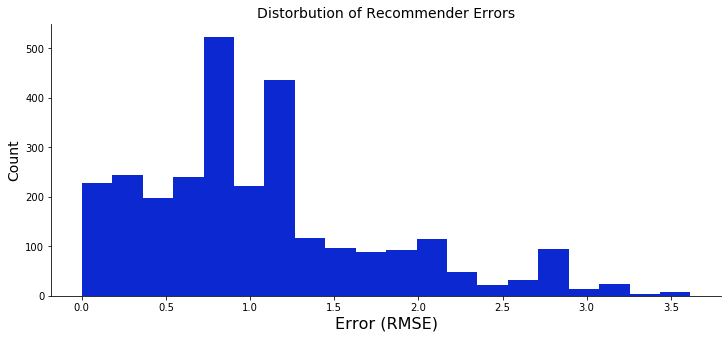

In [24]:
# plot model error
plt.figure(figsize=(12,5))
plt.hist(recommendation_results.err, color=olist_blue, bins=20)
plt.xlabel('Error (RMSE)', size=16)
plt.ylabel('Count', size=14)
plt.title('Distorbution of Recommender Errors', size=14)
sns.despine();

In [27]:
def means_per_rating_group(dataset):
    real_over_three = dataset[dataset.rui > 3].err
    real_three_under = dataset[dataset.rui <= 3].err
    
    print("Overall recommendation system mean error:", dataset.err.mean())
    print("Mean error for products where user rates above 3:", real_over_three.mean())
    print("Mean error for products where user rates below 3:", real_three_under.mean())
    
    return real_over_three, real_three_under

real_over_three, real_three_under = means_per_rating_group(recommendation_results)

Overall recommendation system mean error: 1.0688048619866084
Mean error for products where user rates above 3: 0.8108515398237831
Mean error for products where user rates below 3: 1.583352426638061


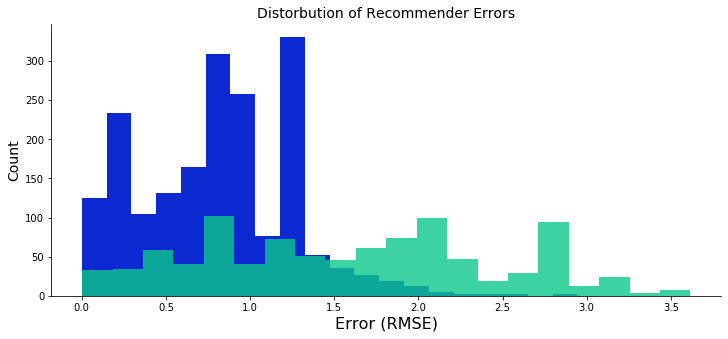

In [22]:
# plot the recommendation system mean for users who rate products higher than 3 and lower than 3
plt.figure(figsize=(12,5))
plt.hist(real_over_three, bins=20, color=olist_blue, label='Actual Rating >3')
plt.hist(real_three_under, bins=20, color=olist_green, alpha=.8, label='Actual Rating <=3')
plt.xlabel('Error (RMSE)', size=16)
plt.ylabel('Count', size=14)
plt.title('Distorbution of Recommender Errors', size=14)
sns.despine();

# First Time Users

First time users are provided a recommendation of hot products on the site as well as popular in your area.

In [78]:
def find_popular_items(data, n_recs):
    top_n_items = data.product_id.value_counts().sort_values(ascending=False)[:n_recs].index
    return list(top_n_items)

In [76]:
def popular_in_your_area(data, state, n_recs):
    location_df = data[data.customer_state == state]
    top_n_items = location_df.product_id.value_counts().sort_values(ascending=False)[:n_recs].index
    return list(top_n_items)

In [87]:
def first_time_recommender(data, uid, n_recs):
    hot_items = find_popular_items(data, n_recs)
    state = data[data.customer_unique_id==uid].customer_state.max()
    popular_in_area = popular_in_your_area(data, state, n_recs)
    
    print(f"Hot items you might like:\n {hot_items}\n")
    print(f"Popular items in your area:\n {popular_in_area}")
    
    recommendation = {'Hot Items': hot_items, 'Area': popular_in_area}
    
    return recommendation

In [88]:
# Example Recommendation
recommendation = first_time_recommender(full_df, 'c71a196d46a70ec611f3922db5755d1d', 3)

Hot items you might like:
 ['99a4788cb24856965c36a24e339b6058', 'aca2eb7d00ea1a7b8ebd4e68314663af', '422879e10f46682990de24d770e7f83d']

Popular items in your area:
 ['99a4788cb24856965c36a24e339b6058', 'aca2eb7d00ea1a7b8ebd4e68314663af', '422879e10f46682990de24d770e7f83d']
